Following Travis' Data Cleaning Process

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

# ============================
# Data Loading and Merging
# ============================

# 1. Load your CSV files into DataFrames
df_assessments = pd.read_csv("assessments.csv")
df_courses = pd.read_csv("courses.csv")
df_studentAssessment = pd.read_csv("studentAssessment.csv")
df_studentInfo = pd.read_csv("studentInfo.csv")
df_studentRegistration = pd.read_csv("studentRegistration.csv")
df_studentVle = pd.read_csv("studentVle.csv")
df_vle = pd.read_csv("vle.csv")

# Count how many unique assessments exist for each module + presentation
df_course_assess_count = (
    df_assessments
    .groupby(["code_module", "code_presentation"])["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "total_assessments"})
)

# Count how many assessments each student attempted
df_attempted_count = (
    df_studentAssessment
    .groupby("id_student")["id_assessment"]
    .count()
    .reset_index()
    .rename(columns={"id_assessment": "num_assessments_attempted"})
)

# Compute average score for each student
df_avg_score = (
    df_studentAssessment
    .groupby("id_student")["score"]
    .mean()  
    .reset_index()
    .rename(columns={"score": "score"})
)

df_vle_clicks = (
    df_studentVle
    .groupby("id_student")["sum_click"]
    .sum()
    .reset_index()
    .rename(columns={"sum_click": "total_vle_clicks"})
)

# Merge data
df_merged = df_studentInfo.merge(df_course_assess_count, on=["code_module", "code_presentation"], how="left")
df_merged = df_merged.merge(df_attempted_count, on="id_student", how="left")
df_merged = df_merged.merge(df_avg_score, on="id_student", how="left")
df_merged = df_merged.merge(df_vle_clicks, on="id_student", how="left")

# Replace NaN with 0 where necessary
df_merged.fillna({"num_assessments_attempted": 0, "total_assessments": 0, "score": 0, "total_vle_clicks": 0}, inplace=True)

# Compute assessment completion ratio
df_merged["assessment_completion_ratio"] = np.where(
    df_merged["total_assessments"] == 0, 0, df_merged["num_assessments_attempted"] / df_merged["total_assessments"]
)

# Filter out withdrawn students
df_merged = df_merged[df_merged["final_result"] != "Withdrawn"].copy()

# Create binary target (Pass/Distinction=1, Fail=0)
df_merged["target"] = df_merged["final_result"].apply(lambda x: 1 if x in ["Pass", "Distinction"] else 0)

# Rename columns for clarity
df_merged.rename(
    columns={
        "highest_education": "HLE",
        "age_band": "Age group",
        "studied_credits": "Credit Distribution",
        "gender": "Gender",
        "region": "Region"
    },
    inplace=True
)

# Select final dataset columns
df_final = df_merged[
    [
        "id_student",
        "code_module",
        "score",
        "Gender",
        "Region",
        "HLE",
        "Age group",
        "Credit Distribution",
        "assessment_completion_ratio",
        "total_vle_clicks",
        "target"
    ]
].copy()

print(df_final.head(10))
print("Number of rows in df_final:", len(df_final))

    id_student code_module  score Gender                Region  \
0        11391         AAA   82.0      M   East Anglian Region   
1        28400         AAA   66.4      F              Scotland   
3        31604         AAA   76.0      F     South East Region   
4        32885         AAA   54.4      F  West Midlands Region   
5        38053         AAA   68.0      M                 Wales   
6        45462         AAA   68.0      M              Scotland   
7        45642         AAA   72.4      F  North Western Region   
8        52130         AAA   71.4      F   East Anglian Region   
9        53025         AAA   78.0      M          North Region   
10       57506         AAA   74.0      M          South Region   

                            HLE Age group  Credit Distribution  \
0              HE Qualification      55<=                  240   
1              HE Qualification     35-55                   60   
3         A Level or Equivalent     35-55                   60   
4        

### **Baseline Logistic Regression Model**
✅ This is the **initial Logistic Regression model** without feature selection or hyperparameter tuning.  
✅ The model includes **all available features**, encoding categorical variables and standardizing numerical features.  
✅ **Class imbalance** is handled using `class_weight='balanced'` and **sample weighting** based on `code_module`.

#### **Model Performance**
- **Accuracy**: **86.13%**

- **Balanced Accuracy**: **82.21%**
- **F1 Score**: **90.17%**
- **Confusion Matrix**:
  - **False Positives (FP)**: 500

  - **False Negatives (FN)**: 278

#### **Key Observations**
- **Top Features:** `score`, `assessment_completion_ratio`, `total_vle_clicks` are the most important.

- **Potential Weak Features:** Features like `Region_Ireland`, `Age group_55<=`, and `HLE_Lower Than A Level` have very small or negative coefficients.
- **High False Positives (500)**: Many students predicted to pass actually failed.


In [4]:
# -----------------------------------
# Define Features and Target
# -----------------------------------
features = [
    'score', 'Gender', 'Region', 'HLE', 'Age group',
    'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks',
    'code_module'  # Include module as a feature
]

X = df_final[features]
y = df_final['target']

# -----------------------------------
# One-hot Encoding of Categorical Features
# -----------------------------------
X_encoded = pd.get_dummies(
    X, 
    columns=['Gender', 'Region', 'HLE', 'Age group', 'code_module'], 
    drop_first=True
)

# -----------------------------------
# Standardize Numerical Features
# -----------------------------------
scaler = StandardScaler()
numerical_features = ['score', 'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks']
X_encoded[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])

# -----------------------------------
# Create Sample Weights by Module
# -----------------------------------
# Compute module counts and assign a weight = 1 / count for each sample
module_counts = df_final['code_module'].value_counts()
df_final['module_weight'] = df_final['code_module'].map(lambda m: 1.0 / module_counts[m])
sample_weights = df_final['module_weight']

# -----------------------------------
# Split Data into Training and Test Sets
# -----------------------------------
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X_encoded, y, sample_weights, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------------
# Logistic Regression with Class Weights and Sample Weights
# -----------------------------------
clf_lr = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced',  # Addressing class imbalance
    random_state=42
)
clf_lr.fit(X_train, y_train, sample_weight=w_train)
y_pred_lr = clf_lr.predict(X_test)

# -----------------------------------
# Model Evaluation for Logistic Regression
# -----------------------------------
accuracy_lr = accuracy_score(y_test, y_pred_lr)
balanced_accuracy_lr = balanced_accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("\nLogistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Balanced Accuracy:", balanced_accuracy_lr)
print("Logistic Regression F1 Score:", f1_lr)
print("Logistic Regression Confusion Matrix:\n", cm_lr)

# -----------------------------------
# Feature Importance
# -----------------------------------
feature_importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Coefficient": clf_lr.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (Logistic Regression):\n", feature_importance)


Logistic Regression Accuracy: 0.861319073083779
Logistic Regression Balanced Accuracy: 0.8220642054323772
Logistic Regression F1 Score: 0.9017180394138454
Logistic Regression Confusion Matrix:
 [[1263  500]
 [ 278 3569]]

Feature Importance (Logistic Regression):
                             Feature  Coefficient
0                             score     0.486091
2       assessment_completion_ratio     0.474513
3                  total_vle_clicks     0.276513
21                  Age group_35-55     0.045876
17             HLE_HE Qualification     0.028118
12              Region_South Region     0.020358
11         Region_South East Region     0.018864
28                  code_module_GGG     0.017708
13         Region_South West Region     0.015112
22                   Age group_55<=     0.008806
8               Region_North Region     0.008751
5       Region_East Midlands Region     0.008569
20  HLE_Post Graduate Qualification     0.004521
6                    Region_Ireland     0.001465

/Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


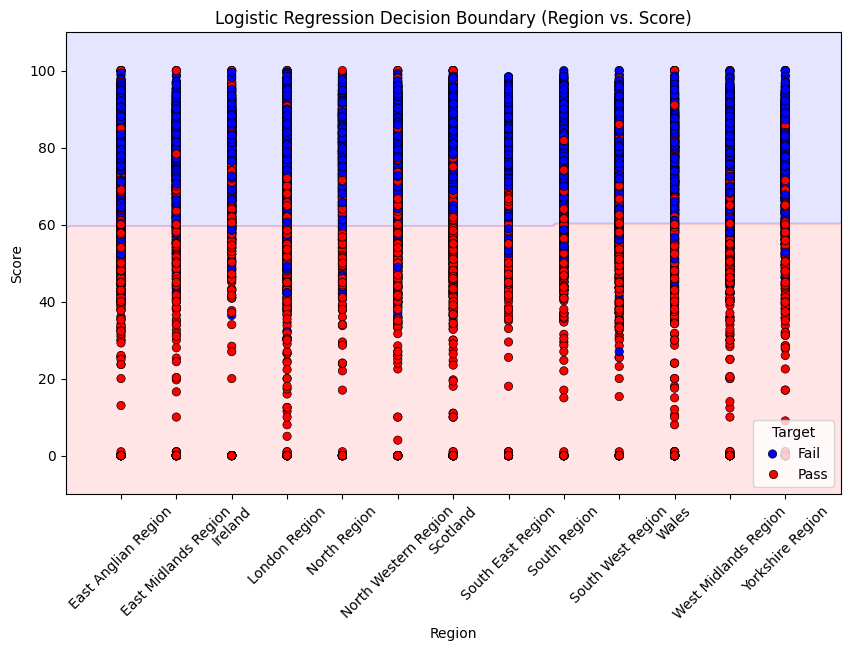

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import ListedColormap

# Select two features: "Region" (Categorical) & "score" (Numerical)
df_plot = df_final[["Region", "score", "target"]].copy()

# Encode "Region" as numerical labels
le = LabelEncoder()
df_plot["Region_encoded"] = le.fit_transform(df_plot["Region"])

# Define features and target
X_plot = df_plot[["Region_encoded", "score"]]
y_plot = df_plot["target"]

# Train a Logistic Regression model using only these two features
clf_plot = LogisticRegression()
clf_plot.fit(X_plot, y_plot)

# Generate a mesh grid to visualize the decision boundary
x_min, x_max = X_plot["Region_encoded"].min() - 1, X_plot["Region_encoded"].max() + 1
y_min, y_max = X_plot["score"].min() - 10, X_plot["score"].max() + 10
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

# Predict on the mesh grid
Z = clf_plot.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(10, 6))
cmap_background = ListedColormap(["#FFAAAA", "#AAAAFF"])  # Red for Fail, Blue for Pass
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.3)

# Scatter plot of actual data points
sns.scatterplot(data=df_plot, x="Region_encoded", y="score", hue="target", palette={0: "red", 1: "blue"}, edgecolor="k")

# Adjust labels
plt.xticks(ticks=np.arange(len(le.classes_)), labels=le.classes_, rotation=45)
plt.xlabel("Region")
plt.ylabel("Score")
plt.title("Logistic Regression Decision Boundary (Region vs. Score)")
plt.legend(title="Target", labels=["Fail", "Pass"])
plt.show()


/Users/alan/Desktop/Year 3 Tri 2/INF2008 Machine Learning/ML_Proj/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


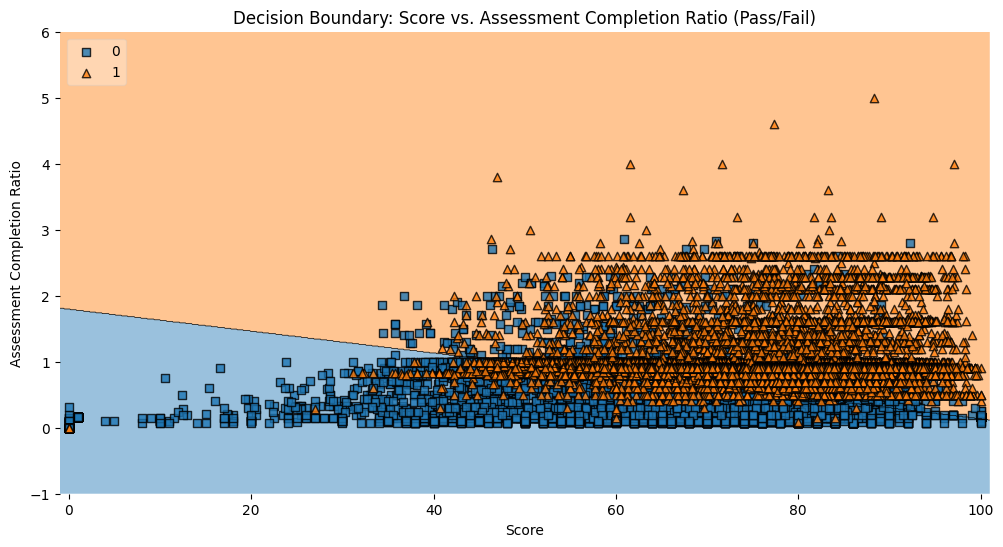

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
from sklearn.linear_model import LogisticRegression

# Select two numerical features (Score & Assessment Completion Ratio)
X_decision = df_final[['score', 'assessment_completion_ratio']]
y_decision = df_final['target'].to_numpy()

# Train Logistic Regression on these two features
clf_decision = LogisticRegression()
clf_decision.fit(X_decision, y_decision)

# Plot Decision Regions
plt.figure(figsize=(12, 6))
plot_decision_regions(X_decision.to_numpy(), y_decision, clf_decision, legend=2)
plt.xlabel("Score")
plt.ylabel("Assessment Completion Ratio")
plt.title("Decision Boundary: Score vs. Assessment Completion Ratio (Pass/Fail)")
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Fit PCA on the encoded dataset (after one-hot encoding and scaling)
pca = PCA(n_components=2)  # Keep top 2 components
X_pca = pca.fit_transform(X_encoded)  # Transform dataset

# Create a DataFrame to show feature importance in each principal component
pc_df = pd.DataFrame(
    pca.components_, 
    columns=X_encoded.columns, 
    index=['PC1', 'PC2']
).transpose()

# Sort features by absolute contribution to PC1 and PC2
pc1_sorted = pc_df["PC1"].abs().sort_values(ascending=False)
pc2_sorted = pc_df["PC2"].abs().sort_values(ascending=False)

print("\n🔹 Features Most Influencing PC1 (X-Axis):")
print(pc1_sorted.head(5))  # Top 5 features for PC1

print("\n🔹 Features Most Influencing PC2 (Y-Axis):")
print(pc2_sorted.head(5))  # Top 5 features for PC2


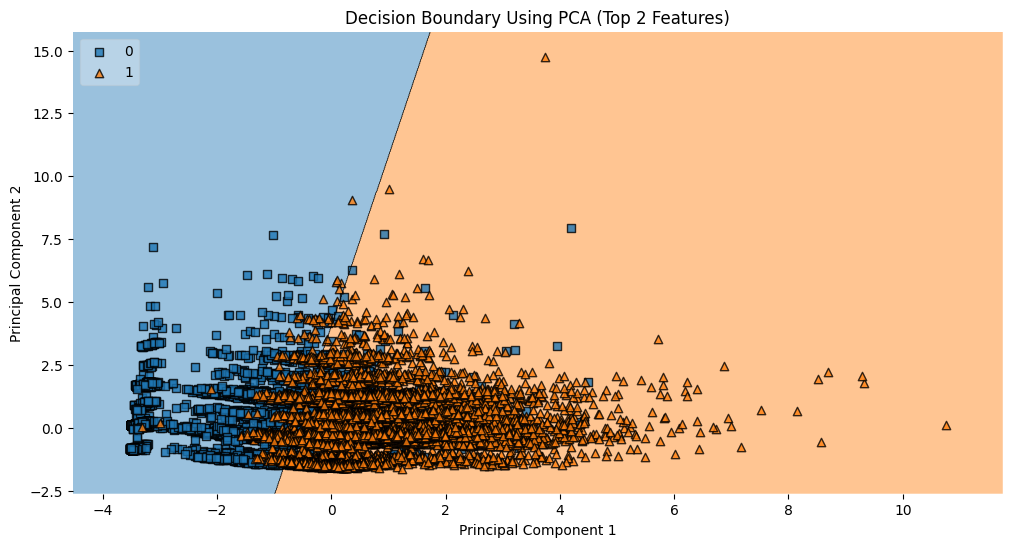

In [8]:
from sklearn.decomposition import PCA

# Apply PCA to reduce features to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)  # Use your fully encoded feature set

# Train a Logistic Regression model on PCA-transformed data
clf_pca = LogisticRegression()
clf_pca.fit(X_pca, y)

# Plot Decision Boundary using PCA components
plt.figure(figsize=(12, 6))
plot_decision_regions(X_pca, y.to_numpy(), clf_pca, legend=2)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Decision Boundary Using PCA (Top 2 Features)")
plt.show()


### **Logistic Regression After Feature Selection**
✅ **Dropped weak features** (`Region_Ireland`, `HLE_Lower Than A Level`, `Age group_55<=`) based on low feature importance.  
✅ **Re-standardized numerical features** to maintain consistency after dropping features.  
✅ **Retrained the model** to check performance improvements.

#### **Model Performance After Dropping Weak Features**
- **Accuracy**: **84.67%** ⬇ (**slight decrease** from 86.13%)

- **Balanced Accuracy**: **83.68%** ⬆ (**improved generalization**)
- **F1 Score**: **88.54%**
- **Confusion Matrix**:
  - **False Positives (FP)**: **335** ⬇ (**Better than before**)

  - **False Negatives (FN)**: **525** ⬆ (**Worsened**)

#### **Key Observations**
- **Balanced Accuracy improved** → The model performs more evenly across pass/fail classes.

- **False Negatives increased** → More failing students were misclassified as passing.
- **Feature Importance changed** → The impact of `score` and `assessment_completion_ratio` increased after dropping weaker features.
- **Next Step:** Tune hyperparameter `C` to reduce false negatives while maintaining balanced accuracy.


In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# -----------------------------------
# 1️⃣ Feature Selection - Drop Weak Predictors
# -----------------------------------
drop_columns = [
    "Region_Ireland", "HLE_Lower Than A Level", "Age group_55<="
]

# Drop weak features
X_encoded = X_encoded.drop(columns=drop_columns, errors="ignore")

# -----------------------------------
# 2️⃣ Standardize Numerical Features (Re-run after dropping)
# -----------------------------------
scaler = StandardScaler()
numerical_features = ['score', 'Credit Distribution', 'assessment_completion_ratio', 'total_vle_clicks']
X_encoded[numerical_features] = scaler.fit_transform(X_encoded[numerical_features])

# -----------------------------------
# 3️⃣ Split Data into Training and Test Sets
# -----------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------------
# 4️⃣ Train Logistic Regression Model
# -----------------------------------
clf_lr = LogisticRegression(
    max_iter=1000, 
    class_weight='balanced',  # Handling class imbalance
    random_state=42
)
clf_lr.fit(X_train, y_train)
y_pred_lr = clf_lr.predict(X_test)

# -----------------------------------
# 5️⃣ Model Evaluation
# -----------------------------------
accuracy_lr = accuracy_score(y_test, y_pred_lr)
balanced_accuracy_lr = balanced_accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)

print("\nModel Performance After Dropping Weak Predictors:")
print("Logistic Regression Accuracy:", accuracy_lr)
print("Logistic Regression Balanced Accuracy:", balanced_accuracy_lr)
print("Logistic Regression F1 Score:", f1_lr)
print("Logistic Regression Confusion Matrix:\n", cm_lr)

# -----------------------------------
# 6️⃣ Feature Importance After Dropping
# -----------------------------------
feature_importance = pd.DataFrame({
    "Feature": X_encoded.columns,
    "Coefficient": clf_lr.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

print("\nFeature Importance (After Dropping Weak Predictors):\n", feature_importance)



Model Performance After Dropping Weak Predictors:
Logistic Regression Accuracy: 0.8467023172905526
Logistic Regression Balanced Accuracy: 0.8367565034728095
Logistic Regression F1 Score: 0.8853944562899787
Logistic Regression Confusion Matrix:
 [[1428  335]
 [ 525 3322]]

Feature Importance (After Dropping Weak Predictors):
                             Feature  Coefficient
0                             score     1.732616
2       assessment_completion_ratio     1.686868
3                  total_vle_clicks     0.635760
18  HLE_Post Graduate Qualification     0.592597
10         Region_South East Region     0.315044
16             HLE_HE Qualification     0.284819
7               Region_North Region     0.272467
17              HLE_No Formal quals     0.265608
11              Region_South Region     0.239631
12         Region_South West Region     0.204448
5       Region_East Midlands Region     0.119034
14      Region_West Midlands Region    -0.030990
15          Region_Yorkshire Region

### **Logistic Regression After Hyperparameter Tuning**
✅ Used **GridSearchCV** to find the best `C` value for regularization.  
✅ The best `C` value found was **0.001**, meaning stronger regularization.  
✅ **Retrained Logistic Regression** with the optimized `C`.

#### **Model Performance After Tuning `C`**
- **Best C Value Found**: **0.001**

- **Accuracy**: **85.42%** ⬆ (Improved after feature selection)
- **Balanced Accuracy**: **83.62%** (Maintained improvement)
- **F1 Score**: **89.27%**
- **Confusion Matrix**:
  - **False Positives (FP)**: **374** ⬆ (More students incorrectly predicted to pass)

  - **False Negatives (FN)**: **444** ⬇ (**Reduced compared to feature selection model**)

#### **Key Observations**
- **Accuracy improved from 84.67% to 85.42%** after tuning `C`.

- **False Negatives decreased** compared to the feature selection model (from 525 to 444).
- **False Positives increased slightly**, meaning more failing students were misclassified as passing.
- **Overall, this is the best-performing model so far** in terms of accuracy and balance.


In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix

# -----------------------------------
# 1️⃣ Hyperparameter Tuning - Optimize `C`
# -----------------------------------
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, class_weight="balanced", solver="saga"),
    param_grid, cv=5, scoring="accuracy"
)
grid_search.fit(X_train, y_train)

best_C = grid_search.best_params_["C"]
print(f"Best C Value Found: {best_C}")

# -----------------------------------
# 2️⃣ Retrain Logistic Regression with Best `C`
# -----------------------------------
clf_lr_tuned = LogisticRegression(C=best_C, max_iter=1000, class_weight="balanced", solver="saga")
clf_lr_tuned.fit(X_train, y_train)
y_pred_tuned = clf_lr_tuned.predict(X_test)

# -----------------------------------
# 3️⃣ Model Evaluation After Tuning
# -----------------------------------
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
balanced_accuracy_tuned = balanced_accuracy_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
cm_tuned = confusion_matrix(y_test, y_pred_tuned)

print("\nModel Performance After Tuning `C`:")
print("Logistic Regression Accuracy:", accuracy_tuned)
print("Logistic Regression Balanced Accuracy:", balanced_accuracy_tuned)
print("Logistic Regression F1 Score:", f1_tuned)
print("Logistic Regression Confusion Matrix:\n", cm_tuned)


Best C Value Found: 0.001

Model Performance After Tuning `C`:
Logistic Regression Accuracy: 0.8541889483065954
Logistic Regression Balanced Accuracy: 0.8362234953800805
Logistic Regression F1 Score: 0.892707240293809
Logistic Regression Confusion Matrix:
 [[1389  374]
 [ 444 3403]]


## **🚀 Comparison of Logistic Regression Models**
| **Model Version**            | **Accuracy** | **Balanced Accuracy** | **F1 Score** | **False Positives (FP)** | **False Negatives (FN)** |
|------------------------------|-------------|----------------------|-------------|------------------|------------------|
| **Baseline Model**           | **86.13%**  | **82.21%**           | **90.17%**  | **500**          | **278**          |
| **Feature Selection Model**  | **84.67%**  | **83.68%** ⬆        | **88.54%**  | **335** ⬇        | **525** ⬆        |
| **Tuned `C` Model (Best)**   | **85.42%**  | **83.62%** ⬆        | **89.27%**  | **374** ⬆        | **444** ⬇        |

### **Key Takeaways**
- **Baseline Model had the highest accuracy (86.13%)** but suffered from **high false positives (500)**.

- **Feature Selection Model improved balance (83.68%)** but introduced **more false negatives (525)**.
- **Tuned `C` Model is the best balance of accuracy and generalization** (85.42% accuracy, 83.62% balanced accuracy).
- **False Positives increased slightly** after tuning, meaning more failing students were misclassified as passing.
- **False Negatives significantly improved** from 525 → 444, meaning fewer passing students were misclassified as failing.
